<a href="https://colab.research.google.com/github/rjnakano/manejo-inventarios-pdg/blob/main/Notebooks/EDA050621V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rjnakano/manejo-inventarios-pdg/blob/main/Notebooks/1-inventarios-EDA.ipynb)

In [1]:
!pip install --upgrade kmodes

Requirement already up-to-date: kmodes in /usr/local/lib/python3.7/dist-packages (0.11.0)


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# !pip install --upgrade kmodes

# Import module for k-protoype cluster
from kmodes.kprototypes import KPrototypes

from sklearn.preprocessing import StandardScaler

# Import module for data visualization
from plotnine import *
import plotnine

# Preparación para el análisis exploratorio de los datos


*   Cargue de los datos
*   Elemento de lista



Configuración del las fuentes almacenadas en el repositorio de Github

In [3]:
sourcepath = 'https://raw.githubusercontent.com/rjnakano/manejo-inventarios-pdg/main/Datos/Raw'
destpath = 'https://raw.githubusercontent.com/rjnakano/manejo-inventarios-pdg/main/Datos/Transformed'

## Cargue de los datos RAW del inventario
Los datos a tratar, corresponden a todos aquellos productos activos que han presentado correcciones durante los inventarios cíclicos y que están ubicados en la bodega principal de la empresa empezando desde enero de 2018

| Field | Description |
| :- | :-- |
| TDATE | Fecha en la que se realizó la corrección al inventario |
| SKU | Identificador del item |
| LOC | Ubicación del item en la bodega compuesta por tres dimensiones (pasillo, columna y estantería) |
| QTY | Corrección (cantidad), donde las menores a 0 representan las unidades faltantes mientras que las mayores a 0 la unidades adicionales no contabilizadas |
| AISLE | Número del pasillo de la ubicación del item |
| COLUMN | Columna en del pasillo en la que se encuentra el item |
| SHELF | Número de la estantería en la que se encuentra el item |
| TYPE | Tipo de ubicación |
| IG | Agrupación a la que pertenece el item |
| IPG | Agrupación de precio a la que pertence el item |
| HTS | Clasificación fiscal (Gobierno - U.S. International Trade Commission) del item |
| CLASS | Flag para identificar si se mantiene inventario de un item (1) o no (0) |
| PLANNING | Flag para identificar si un item se planea (1) o no (0) |
| ABC | Clasificación ABC de inventario |
| UOM | Tipo de unidad de medida del item |
| CREATION | Fecha de creación del item en el sistema |
| CAT | Categoría de agrupación del item |
| COSTX | Costo extendido de la transacción, costo x cantidad |
| QTYBEFORE | Número de unidades antes de la corrección |
| QTYVAR | Porcentaje de variación (QTY/QTYBEFORE) |
| WEIGHT | Peso del item |
| LENGTH | Largo del item |
| HEIGHT | Altura del item |
| WIDTH | Ancho del item |
| CONTRPERC | Porcentaje de contribución del item (ABC)|


In [4]:
filename = 'LOCTRANSCX.CSV'
df = pd.read_csv(f"{sourcepath}/{filename}")

In [5]:
pd.set_option('max_columns', df.shape[1])
df.head(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
0,20180210,SKU3921,17Q3,-1.0,17.0,Q,3,LOC4,IG56,NaN,HTS119,1,1,B,PC,20161028,CAT17,-289.8802,38.0,-2.63,0.0,0.0,0.0,0.0,0.01
1,20180210,SKU3922,17Q2,1.0,17.0,Q,2,LOC4,IG56,NaN,HTS119,1,1,B,PC,20161028,CAT17,289.5527,4.0,25.00,0.0,0.0,0.0,0.0,0.00
2,20180210,SKU3923,17W2,4.0,17.0,W,2,LOC4,IG56,NaN,HTS119,1,1,C,PC,20161028,CAT17,1111.3121,8.0,50.00,0.0,0.0,0.0,0.0,0.00
3,20180210,SKU3924,17B2,-1.0,17.0,B,2,LOC4,IG56,NaN,HTS119,1,1,B,PC,20161028,CAT17,-266.8633,11.0,-9.09,0.0,0.0,0.0,0.0,0.00
4,20180210,SKU3926,15P7,-2.0,15.0,P,7,LOC4,IG56,NaN,HTS119,1,1,C,PC,20161028,CAT17,-517.0436,18.0,-11.11,0.0,0.0,0.0,0.0,0.00


In [6]:
df.tail(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
17002,20201213,SKU8964,23C10,1.0,23.0,C,10,LOC5,IG5,IPG1604,HTS67,1,0,C,BX,20000930,CAT2,316.3834,0.0,100.00,45.0,162.0,2.375,6.00,0.0
17003,20201213,SKU8971,21I2,2.0,21.0,I,2,LOC4,IG5,IPG1604,HTS67,1,0,C,BX,20001001,CAT2,626.9100,0.0,100.00,45.0,162.0,2.375,6.00,0.0
17004,20201213,SKU8972,22F8,15.0,22.0,F,8,LOC4,IG5,IPG1604,HTS67,1,0,C,BX,20000930,CAT2,4959.6974,11.0,136.36,45.0,162.0,2.375,6.00,0.0
17005,20201213,SKU8972,24I4,-4.0,24.0,I,4,LOC4,IG5,IPG1604,HTS67,1,0,C,BX,20000930,CAT2,-1322.5860,4.0,-100.00,45.0,162.0,2.375,6.00,0.0
17006,20201213,SKU8979,20G1,-1.0,20.0,G,1,LOC4,IG5,IPG1880,HTS67,1,0,C,BX,20050603,CAT2,-255.2001,2.0,-50.00,39.0,162.0,2.250,4.75,0.0


In [7]:
df.shape

(17007, 25)

## Eliminación de duplicados
Debido al proceso de generación de los datos, en el cual se toma la información de dos fuentes diferentes, cabe la posibilidad de la generación de duplicados los cuales deberán ser manejados.


*   Identificación de registros duplicados 
*   Validación de registros
*   Eliminación de los registros extras
*   Verificación del proceso



In [8]:
df[df.duplicated()==True]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
10286,20201213,SKU10071,07G7,1.0,7.0,G,7,LOC4,IG8,IPG1453,HTS15,1,1,A,BX,20150813,CAT3,2094.1441,0.0,100.0,33.00,13.0,8.5,13.0,0.10
10288,20201213,SKU10071,10K2,1.0,10.0,K,2,LOC4,IG8,IPG1453,HTS15,1,1,A,BX,20150813,CAT3,2094.1441,0.0,100.0,33.00,13.0,8.5,13.0,0.10
10355,20201213,SKU10231,15U2,1500.0,15.0,U,2,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,100.0,0.01,0.5,0.5,0.5,0.05
10358,20201213,SKU10231,99D28,1500.0,99.0,D,28,LOC5,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,100.0,0.01,0.5,0.5,0.5,0.05
10469,20201213,SKU10347,15G2,2.0,15.0,G,2,LOC4,IG57,NaN,HTS151,1,0,A,BX,20180924,CAT17,433.5837,0.0,100.0,2.00,4.0,3.0,16.0,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16899,20201213,SKU1759,11G2,1.0,11.0,G,2,LOC4,IG64,NaN,HTS15,1,1,A,BX,20131101,CAT14,700.3199,0.0,100.0,22.00,16.0,14.0,12.0,0.09
16901,20201213,SKU1760,11U3,1.0,11.0,U,3,LOC4,IG64,NaN,HTS15,1,1,A,BX,20131101,CAT14,791.6199,0.0,100.0,22.00,16.0,14.0,12.0,0.02
16903,20201213,SKU1760,37I3,1.0,37.0,I,3,LOC4,IG64,NaN,HTS15,1,1,A,BX,20131101,CAT14,791.6199,0.0,100.0,22.00,16.0,14.0,12.0,0.02
16954,20201213,SKU6156,21G9,1.0,21.0,G,9,LOC4,IG7,IPG1815,HTS95,1,1,A,BX,20160721,CAT8,1023.6613,0.0,100.0,60.00,192.0,3.0,7.0,0.04


In [9]:
df[(df.SKU == 'SKU10231') & (df.TDATE == 20201213)]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
10354,20201213,SKU10231,15U2,1500.0,15.0,U,2,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,100.0,0.01,0.5,0.5,0.5,0.05
10355,20201213,SKU10231,15U2,1500.0,15.0,U,2,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,100.0,0.01,0.5,0.5,0.5,0.05
10356,20201213,SKU10231,17R6,-3710.0,17.0,R,6,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,-2865.7695,3710.0,-100.0,0.01,0.5,0.5,0.5,0.05
10357,20201213,SKU10231,99D28,1500.0,99.0,D,28,LOC5,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,100.0,0.01,0.5,0.5,0.5,0.05
10358,20201213,SKU10231,99D28,1500.0,99.0,D,28,LOC5,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,100.0,0.01,0.5,0.5,0.5,0.05


In [10]:
df.drop_duplicates(keep='first', inplace=True)
df[(df.SKU == 'SKU10231') & (df.TDATE == 20201213)]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,IPG,HTS,CLASS,PLANNING,ABC,UOM,CREATION,CAT,COSTX,QTYBEFORE,QTYVAR,WEIGHT,LENGTH,HEIGHT,WIDTH,CONTRPERC
10354,20201213,SKU10231,15U2,1500.0,15.0,U,2,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,100.0,0.01,0.5,0.5,0.5,0.05
10356,20201213,SKU10231,17R6,-3710.0,17.0,R,6,LOC4,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,-2865.7695,3710.0,-100.0,0.01,0.5,0.5,0.5,0.05
10357,20201213,SKU10231,99D28,1500.0,99.0,D,28,LOC5,IG51,IPG294,HTS15,1,1,A,PC,20170816,CAT16,1158.6669,0.0,100.0,0.01,0.5,0.5,0.5,0.05


In [11]:
df.shape

(16333, 25)

## Corrección de formatos y nombres de campos

### Cambio de tipos

Es necesario modificar ciertas columnas para que se comporten de acuerdo a las definiciones del negocio

| **Field** | **From** | **To** |
| :-: | :-: | :-: |
| TDATE | Entero | Fecha |
| CREATION | Entero | Fecha |
| CLASS | Entero | Cadena |
| AISLE | Real | Cadena |
| PLANNING | Real | Cadena |
| SHELF | Real | Cadena |


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16333 entries, 0 to 17006
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TDATE      16333 non-null  int64  
 1   SKU        16333 non-null  object 
 2   LOC        16333 non-null  object 
 3   QTY        16333 non-null  float64
 4   AISLE      16261 non-null  float64
 5   COLUMN     16261 non-null  object 
 6   SHELF      16333 non-null  int64  
 7   TYPE       16261 non-null  object 
 8   IG         16333 non-null  object 
 9   IPG        8225 non-null   object 
 10  HTS        16323 non-null  object 
 11  CLASS      16333 non-null  int64  
 12  PLANNING   16333 non-null  int64  
 13  ABC        16333 non-null  object 
 14  UOM        16333 non-null  object 
 15  CREATION   16333 non-null  int64  
 16  CAT        16333 non-null  object 
 17  COSTX      16333 non-null  float64
 18  QTYBEFORE  16333 non-null  float64
 19  QTYVAR     16333 non-null  float64
 20  WEIGHT

In [13]:
df.TDATE = pd.to_datetime(df.TDATE, format='%Y%m%d') 
df.CREATION = pd.to_datetime(df.CREATION, format='%Y%m%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16333 entries, 0 to 17006
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   TDATE      16333 non-null  datetime64[ns]
 1   SKU        16333 non-null  object        
 2   LOC        16333 non-null  object        
 3   QTY        16333 non-null  float64       
 4   AISLE      16261 non-null  float64       
 5   COLUMN     16261 non-null  object        
 6   SHELF      16333 non-null  int64         
 7   TYPE       16261 non-null  object        
 8   IG         16333 non-null  object        
 9   IPG        8225 non-null   object        
 10  HTS        16323 non-null  object        
 11  CLASS      16333 non-null  int64         
 12  PLANNING   16333 non-null  int64         
 13  ABC        16333 non-null  object        
 14  UOM        16333 non-null  object        
 15  CREATION   16333 non-null  datetime64[ns]
 16  CAT        16333 non-null  object       

In [14]:
df.CLASS=df.CLASS.astype(str)
df['AISLE'].fillna(0, inplace = True) 
#df[df['AISLE'].notna()].AISLE=df[df['AISLE'].notna()].AISLE.astype(int)

In [15]:
df['AISLE']=df['AISLE'].astype(int)
df['AISLE']=df['AISLE'].astype(str)

In [16]:
df.TDATE.head()

0   2018-02-10
1   2018-02-10
2   2018-02-10
3   2018-02-10
4   2018-02-10
Name: TDATE, dtype: datetime64[ns]

In [17]:
df.PLANNING = df.PLANNING.astype(str)
df.SHELF = df.SHELF.astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16333 entries, 0 to 17006
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   TDATE      16333 non-null  datetime64[ns]
 1   SKU        16333 non-null  object        
 2   LOC        16333 non-null  object        
 3   QTY        16333 non-null  float64       
 4   AISLE      16333 non-null  object        
 5   COLUMN     16261 non-null  object        
 6   SHELF      16333 non-null  object        
 7   TYPE       16261 non-null  object        
 8   IG         16333 non-null  object        
 9   IPG        8225 non-null   object        
 10  HTS        16323 non-null  object        
 11  CLASS      16333 non-null  object        
 12  PLANNING   16333 non-null  object        
 13  ABC        16333 non-null  object        
 14  UOM        16333 non-null  object        
 15  CREATION   16333 non-null  datetime64[ns]
 16  CAT        16333 non-null  object       

### Renombramiento
| **Original Name** | **New Name** |
| :-: | :-: |
| WEIGHT | PESO |
| LENGTH | LARGO |
| HEIGHT | ALTO |
| WIDTH | ANCHO |

In [18]:
df = df.rename(columns={"WEIGHT":"PESO","LENGTH":"LARGO","HEIGHT":"ALTO","WIDTH":"ANCHO" })

## Manejo de registros con nulos
* Eliminación de las columnas **IPG** por su gran cantidad de valores vacios y **CREATION** ya que define la fecha de creación en el sistema del producto en su tabla maestra.
* Eliminación de registros con todos los valores nulos
* Crearemos dos data frames:
    * df_na_free: eliminará los registros nulos. 
    * df_imp: Reemplazará los valores NA con valores del negocio.

In [19]:
# Borramos las columnas irrelevantes
df = df.drop(['CREATION','IPG'], axis=1)

In [20]:
# Borramos cualquier fila con todos los valores nulos
df.dropna(axis=0,how="all", inplace=True)

In [21]:
# Finding the null values.
print(df.isnull().sum())

TDATE         0
SKU           0
LOC           0
QTY           0
AISLE         0
COLUMN       72
SHELF         0
TYPE         72
IG            0
HTS          10
CLASS         0
PLANNING      0
ABC           0
UOM           0
CAT           0
COSTX         0
QTYBEFORE     0
QTYVAR        0
PESO          0
LARGO         0
ALTO          0
ANCHO         0
CONTRPERC     0
dtype: int64


### Imputación de valores nulos
De acuerdo a las definiciones del negocio, es válido imputar las ubicaciones de los items que tienen valores nulos, con un sólo valor que les permita reconocerlo en el sistema, aunque no esté ubicado claramente dentro de la bodega.

In [22]:
df.loc[pd.isnull(df['TYPE']), 'TYPE'] = 'AREA' 
df.loc[pd.isnull(df['AISLE']), 'AISLE'] = df['LOC']
df.loc[pd.isnull(df['COLUMN']), 'COLUMN'] = ''
df['HTS'].fillna("No HTS", inplace = True) 
print(df.isnull().sum())
print(df.shape)

TDATE        0
SKU          0
LOC          0
QTY          0
AISLE        0
COLUMN       0
SHELF        0
TYPE         0
IG           0
HTS          0
CLASS        0
PLANNING     0
ABC          0
UOM          0
CAT          0
COSTX        0
QTYBEFORE    0
QTYVAR       0
PESO         0
LARGO        0
ALTO         0
ANCHO        0
CONTRPERC    0
dtype: int64
(16333, 23)


In [23]:
df = df[((df['QTYVAR']>0) & df['COSTX']>0) | ((df['QTYVAR']<0) & (df['COSTX']<0))]

In [24]:
df.shape

(16329, 23)

# Análisis exploratorio de datos

## Variables Cuantitativas

In [27]:
df.describe()

,QTY,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC
count,16329.000000,1.632900e+04,16329.000000,16329.000000,16329.000000,16329.000000,16329.000000,16329.000000,16329.000000
mean,-23.221646,-6.794744e+01,541.684932,51.395735,13.660491,54.033500,4.842432,5.715024,0.089157
std,1271.270593,1.332696e+04,4510.548041,1045.811452,43.087609,64.992839,4.700822,4.384348,0.420454
min,-80500.000000,-2.298156e+05,0.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.000000,-7.367802e+02,2.000000,-50.060000,0.470000,6.000000,1.500000,2.500000,0.000000
50%,-1.000000,-3.371920e+01,18.000000,-1.190000,2.037000,12.000000,3.500000,5.500000,0.010000
75%,4.000000,6.162533e+02,114.000000,48.350000,10.000000,102.000000,7.250000,8.000000,0.030000
max,74000.000000,1.374824e+06,322475.000000,73950.000000,3250.000000,241.000000,50.500000,48.000000,4.630000


## Variables Categóricas

### Análisis Univariado

In [28]:
df.select_dtypes('object').nunique()

SKU         5295
LOC         4368
AISLE         44
COLUMN        34
SHELF         24
TYPE           4
IG            65
HTS          134
CLASS          2
PLANNING       5
ABC            3
UOM           14
CAT           16
dtype: int64

In [29]:
df['PLANNING'].value_counts()

1    13481
0     2833
4        9
2        4
9        2
Name: PLANNING, dtype: int64

In [30]:
df=df[df['PLANNING']!='9']

In [32]:
# Regla del negocio (diferentes tipos de planeacion)
df.loc[(df['PLANNING']!='0') & (df['PLANNING']!='1'),'PLANNING']='1'

In [33]:
df['PLANNING'].value_counts()

1    13494
0     2833
Name: PLANNING, dtype: int64

In [34]:
df['ABC'].value_counts()

A    7133
C    5735
B    3459
Name: ABC, dtype: int64

In [35]:
df['CLASS'].value_counts()

1    15098
2     1229
Name: CLASS, dtype: int64

In [36]:
df['PLANNING'].value_counts(normalize=True)

1    0.826484
0    0.173516
Name: PLANNING, dtype: float64

In [37]:
df['CAT'].value_counts(normalize=True)*100

CAT17    24.438047
CAT12    15.759172
CAT16    15.091566
CAT8     13.676732
CAT14    13.229620
CAT7      7.558033
CAT3      3.233907
CAT10     1.549580
CAT5      1.231090
CAT2      1.163717
CAT9      0.979972
CAT1      0.894224
CAT4      0.636982
CAT15     0.508360
CAT6      0.042874
CAT11     0.006125
Name: CAT, dtype: float64

### Análisis Multivariado

In [38]:
contingency = pd.crosstab(df['CLASS'], df['PLANNING']) 
contingency 

PLANNING,0,1
CLASS,,
1,1604,13494
2,1229,0


In [39]:
contingency_pct= pd.crosstab(df['CLASS'], df['PLANNING'],normalize='index') 

In [40]:
contingency_pct

PLANNING,0,1
CLASS,,
1,0.106239,0.893761
2,1.000000,0.000000


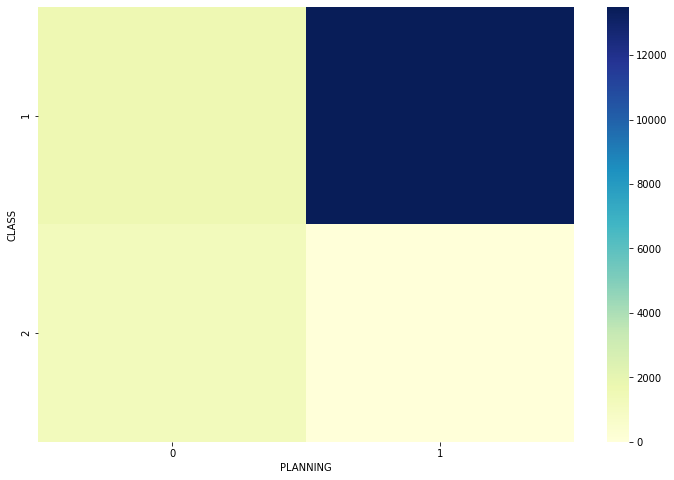

In [41]:
plt.figure(figsize=(12,8)) 
sns.heatmap(contingency, annot=False, cmap="YlGnBu")

In [43]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingency) 
# Print the p-value
print(p)
# Now, p < 0.05 is the usual test for dependence. In this case p is lower than 0.05, so we believe the variables are dependent

0.0


In [49]:
contingency = pd.crosstab(df['IG'], df['CAT']) 

In [50]:
contingency

CAT,CAT1,CAT10,CAT11,CAT12,CAT14,CAT15,CAT16,CAT17,CAT2,CAT3,CAT4,CAT5,CAT6,CAT7,CAT8,CAT9
IG,,,,,,,,,,,,,,,,
IG10,0,0,0,0,0,0,0,0,0,0,104,0,0,0,0,0
IG11,0,0,0,0,0,0,0,0,0,0,0,201,0,0,0,0
IG12,0,0,0,0,0,0,0,0,77,0,0,0,0,0,0,0
IG13,0,0,0,0,0,0,0,0,0,344,0,0,0,0,0,0
IG14,0,0,0,0,0,0,0,0,0,0,0,0,0,22,1043,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IG7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,299,0
IG70,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0
IG71,0,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0


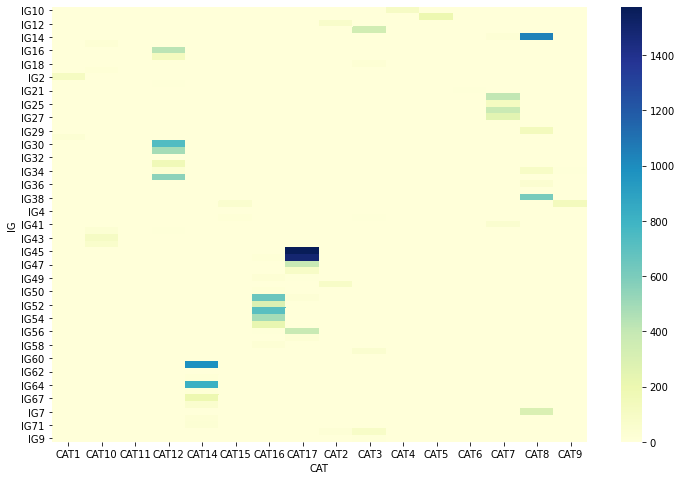

In [51]:
plt.figure(figsize=(12,8)) 
sns.heatmap(contingency, annot=False, cmap="YlGnBu")

In [52]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(contingency) 
# Print the p-value
print(p)
# Now, p < 0.05 is the usual test for dependence. In this case p is lower than 0.05, so we believe the variables are dependent

0.0


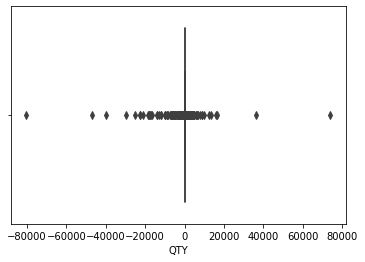

In [53]:
sns.boxplot(x=df['QTY'])

In [55]:
z = np.abs(stats.zscore(df.QTY))
#z = stats.zscore(df.QTY)
df['Zqty']=z
print(z)
# Z score = número de desviaciones estándar respecto a la media

[0.01746732 0.01904051 0.02140028 ... 0.03005278 0.01510755 0.01746732]


In [56]:
df.sample(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,ABC,UOM,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty
9495,2020-01-29,SKU4231,15T2,8.0,15,T,2,LOC4,IG46,HTS121,1,1,C,PR,CAT17,571.2744,64.0,12.50,2.64,13.25,4.50,4.75,0.00,0.024547
6211,2019-03-05,SKU5471,08D1,15.0,8,D,1,LOC4,IG14,HTS15,1,0,A,BX,CAT8,1249.3395,79.0,18.99,2.00,8.00,8.00,8.00,0.01,0.030053
8910,2019-11-14,SKU10740,04B3,-3.0,4,B,3,LOC4,IG35,HTS51,1,1,A,YD,CAT12,-161.7082,3.0,-100.00,2.57,121.50,7.25,7.25,0.03,0.015894
9875,2020-03-05,SKU1636,07P2,-4.0,7,P,2,LOC4,IG64,HTS15,1,1,A,BX,CAT14,-1375.1535,7.0,-57.14,3.00,6.00,6.00,6.00,0.14,0.015108
9710,2020-02-19,SKU3080,10J3,-5.0,10,J,3,LOC4,IG14,HTS16,1,1,B,BX,CAT8,-610.0357,12.0,-41.67,0.83,6.00,6.50,6.00,0.00,0.014321


In [57]:
df['QTY'].describe()

count    16327.000000
mean       -23.206361
std       1271.347623
min     -80500.000000
25%         -6.000000
50%         -1.000000
75%          4.000000
max      74000.000000
Name: QTY, dtype: float64

In [58]:
df['Zqty'].describe()

count    16327.000000
mean         0.100919
std          0.994925
min          0.000162
25%          0.016681
50%          0.019041
75%          0.026906
max         63.302323
Name: Zqty, dtype: float64

In [62]:
print('Dentro de 1 desviación estándar:', df.loc[df['Zqty'] < 1,'Zqty'].count(), round(df.loc[df['Zqty'] < 1,'Zqty'].count()/len(df)*100,2),'%')
print('Entre 1 y 2 desviaciones estándar:', df.loc[(df['Zqty'] >= 1) & (df['Zqty'] < 2),'Zqty'].count())
print('Entre 2 y 3 desviaciones estándar:', df.loc[(df['Zqty'] >= 2) & (df['Zqty'] < 3),'Zqty'].count())
print('Más de de 3 desviación estándar:', df.loc[df['Zqty'] > 3,'Zqty'].count())
print('Más de de 4 desviación estándar:', df.loc[df['Zqty'] > 4,'Zqty'].count())
print('Más de de 10 desviación estándar:', df.loc[df['Zqty'] > 10,'Zqty'].count())
print(df.loc[df['Zqty'] < 1,'Zqty'].count() + df.loc[(df['Zqty'] >= 1) & (df['Zqty'] < 2),'Zqty'].count() + df.loc[(df['Zqty'] >= 2) & (df['Zqty'] < 3),'Zqty'].count() + df.loc[df['Zqty'] > 3,'Zqty'].count())

Dentro de 1 desviación estándar: 16120 98.73 %
Entre 1 y 2 desviaciones estándar: 112
Entre 2 y 3 desviaciones estándar: 27
Más de de 3 desviación estándar: 68
Más de de 4 desviación estándar: 52
Más de de 10 desviación estándar: 22
16327


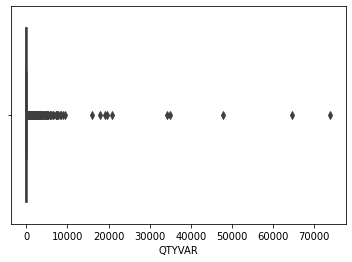

In [63]:
sns.boxplot(x=df['QTYVAR'])

In [65]:
df[df['QTYVAR']>10000]

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,ABC,UOM,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty
1388,2018-04-23,SKU7186,14O7,159.0,14,O,7,LOC4,IG45,HTS16,1,0,B,PC,CAT17,4.912834e+03,1.0,15900.00,0.800,6.5,4.0,7.0,0.00,0.143322
2449,2018-07-23,SKU1916,16O4,208.0,16,O,4,LOC4,IG49,HTS119,1,1,C,PC,CAT16,4.778136e+03,1.0,20800.00,1.130,30.0,1.5,1.5,0.00,0.181865
3271,2018-09-19,SKU6513,02K1,1719.0,2,K,1,LOC4,IG38,HTS61,1,1,A,SQFT,CAT8,3.372806e+03,9.0,19100.00,0.060,148.0,3.0,11.0,0.16,1.370404
4142,2018-10-29,SKU10933,20D2,647.0,20,D,2,LOC4,IG48,HTS24,1,0,B,TB,CAT17,1.374824e+06,1.0,64700.00,5.000,192.0,1.0,2.0,0.00,0.527178
5215,2019-01-16,SKU6481,02P1,3327.0,2,P,1,LOC4,IG38,HTS61,1,1,A,SQFT,CAT8,8.974852e+03,17.0,19570.59,0.100,148.0,3.0,11.0,0.02,2.635242
5228,2019-01-16,SKU6580,02P1,1746.0,2,P,1,LOC4,IG38,HTS61,1,1,A,SQFT,CAT8,9.931164e+03,5.0,34920.00,0.070,148.0,3.0,7.0,0.19,1.391642
5232,2019-01-16,SKU6621,02K3,1479.0,2,K,3,LOC4,IG38,HTS61,1,1,A,SQFT,CAT8,4.704755e+03,2.0,73950.00,0.020,148.0,3.0,7.0,0.01,1.181622
5562,2019-01-29,SKU4707,04D1,343.0,4,D,1,LOC4,IG30,HTS46,1,1,A,YD,CAT12,8.827518e+03,1.0,34300.00,2.336,112.0,8.5,8.5,0.16,0.288055
9155,2019-12-23,SKU7427,4.10E+14,179.0,41,E,13,LOC5,IG26,HTS56,1,1,A,BX,CAT7,2.468232e+04,1.0,17900.00,4.000,13.0,3.0,12.0,0.32,0.159054
10583,2020-12-13,SKU10605,23F1,479.0,23,F,1,LOC4,IG55,HTS95,1,1,C,FT,CAT16,1.151114e+03,1.0,47900.00,70.000,194.0,4.0,4.0,0.00,0.395031


In [66]:
z = np.abs(stats.zscore(df.QTYVAR))
#z = stats.zscore(df.QTYVAR)
df['ZqtyVar']=z
print(z)
# Z score = número de desviaciones estándar respecto a la media

[0.05167046 0.02525158 0.00134741 ... 0.08122716 0.14477242 0.09696408]


In [67]:
df.sample(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,ABC,UOM,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar
5377,2019-01-21,SKU6739,02X1,3.0,2,X,1,LOC4,IG38,HTS61,1,1,C,SQFT,CAT8,5.5994,878.0,0.34,25.00,148.00,4.00,12.00,0.00,0.020614,0.048831
6280,2019-03-12,SKU4553,21H4,-4.0,21,H,4,LOC4,IG56,HTS119,1,1,A,PC,CAT17,-1203.6578,4.0,-100.00,7.40,81.75,4.25,4.00,0.01,0.015108,0.144772
7747,2019-07-03,SKU130,07D2,18.0,7,D,2,LOC4,IG14,HTS14,1,1,A,RL,CAT8,1566.5470,114.0,15.79,2.66,8.25,1.25,8.25,0.03,0.032413,0.034058
1183,2018-04-03,SKU8176,19H8,-6.0,19,H,8,LOC4,IG47,HTS119,1,1,A,PC,CAT17,-241.9935,134.0,-4.48,4.21,96.00,1.00,1.00,0.03,0.013534,0.053439
7064,2019-04-24,SKU7859,16G3,1.0,16,G,3,LOC4,IG45,HTS24,1,1,C,PC,CAT17,13.1457,636.0,0.16,0.40,7.50,1.00,5.00,0.00,0.019041,0.049003


In [68]:
df['QTYVAR'].describe()

count    16327.000000
mean        51.409175
std       1045.874701
min       -100.000000
25%        -50.030000
50%         -1.190000
75%         48.665000
max      73950.000000
Name: QTYVAR, dtype: float64

In [69]:
df['ZqtyVar'].describe()

count    16327.000000
mean         0.122595
std          0.992487
min          0.000057
25%          0.046461
50%          0.053143
75%          0.142078
max         70.659376
Name: ZqtyVar, dtype: float64

In [72]:
print('Dentro de 1 desviación estándar:', df.loc[df['ZqtyVar'] < 1,'ZqtyVar'].count(), round(df.loc[df['ZqtyVar'] < 1,'ZqtyVar'].count()/len(df)*100,2),'%')
print('Entre 1 y 2 desviaciones estándar:', df.loc[(df['ZqtyVar'] >= 1) & (df['ZqtyVar'] < 2),'ZqtyVar'].count())
print('Entre 2 y 3 desviaciones estándar:', df.loc[(df['ZqtyVar'] >= 2) & (df['ZqtyVar'] < 3),'ZqtyVar'].count())
print('Más de de 3 desviación estándar:', df.loc[df['ZqtyVar'] > 3,'ZqtyVar'].count())
print('Más de de 4 desviación estándar:', df.loc[df['ZqtyVar'] > 4,'ZqtyVar'].count())
print('Más de de 10 desviación estándar:', df.loc[df['ZqtyVar'] > 10,'ZqtyVar'].count())
print(df.loc[df['ZqtyVar'] < 1,'ZqtyVar'].count() + df.loc[(df['ZqtyVar'] >= 1) & (df['ZqtyVar'] < 2),'ZqtyVar'].count() + df.loc[(df['ZqtyVar'] >= 2) & (df['ZqtyVar'] < 3),'ZqtyVar'].count() + df.loc[df['ZqtyVar'] > 3,'ZqtyVar'].count())

Dentro de 1 desviación estándar: 16193 99.18 %
Entre 1 y 2 desviaciones estándar: 57
Entre 2 y 3 desviaciones estándar: 26
Más de de 3 desviación estándar: 51
Más de de 4 desviación estándar: 38
Más de de 10 desviación estándar: 10
16327


In [73]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

QTY            10.000000
COSTX        1354.312450
QTYBEFORE     112.000000
QTYVAR         98.695000
PESO            9.530000
LARGO          96.000000
ALTO            5.750000
ANCHO           5.500000
CONTRPERC       0.030000
Zqty            0.010226
ZqtyVar         0.095617
dtype: float64


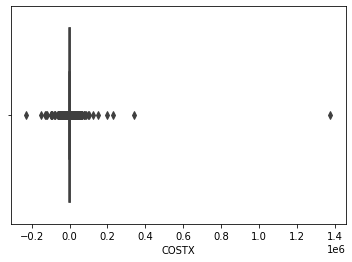

In [74]:
sns.boxplot(x=df['COSTX'])

In [75]:
z = np.abs(stats.zscore(df.COSTX))
#z = stats.zscore(df.COSTX)
df['ZcostX']=z
print(z)
# Z score = número de desviaciones estándar respecto a la media

[0.01665688 0.02682004 0.08847957 ... 0.37723764 0.09414448 0.01405471]


In [76]:
df['ZcostX'].describe()

count    1.632700e+04
mean     1.912117e-01
std      9.815789e-01
min      8.826506e-07
25%      1.493653e-02
50%      5.117434e-02
75%      1.455416e-01
max      1.031630e+02
Name: ZcostX, dtype: float64

In [78]:
print('Dentro de 1 desviación estándar:', df.loc[df['ZcostX'] < 1,'ZcostX'].count(), round(df.loc[df['ZcostX'] < 1,'ZcostX'].count()/len(df)*100,2),'%')
print('Entre 1 y 2 desviaciones estándar:', df.loc[(df['ZcostX'] >= 1) & (df['ZcostX'] < 2),'ZcostX'].count())
print('Entre 2 y 3 desviaciones estándar:', df.loc[(df['ZcostX'] >= 2) & (df['ZcostX'] < 3),'ZcostX'].count())
print('Más de de 3 desviación estándar:', df.loc[df['ZcostX'] > 3,'ZcostX'].count())
print('Más de de 4 desviación estándar:', df.loc[df['ZcostX'] > 4,'ZcostX'].count())
print('Más de de 10 desviación estándar:', df.loc[df['ZcostX'] > 10,'ZcostX'].count())
print(df.loc[df['ZcostX'] < 1,'ZcostX'].count() + df.loc[(df['ZcostX'] >= 1) & (df['ZcostX'] < 2),'ZcostX'].count() + df.loc[(df['ZcostX'] >= 2) & (df['ZcostX'] < 3),'ZcostX'].count() + df.loc[df['ZcostX'] > 3,'ZcostX'].count())

Dentro de 1 desviación estándar: 15719 96.28 %
Entre 1 y 2 desviaciones estándar: 412
Entre 2 y 3 desviaciones estándar: 109
Más de de 3 desviación estándar: 87
Más de de 4 desviación estándar: 51
Más de de 10 desviación estándar: 7
16327


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# drivepath = '/content/drive/MyDrive/Colab Notebooks/data'
# df_imp.to_csv('{}/dataframe_imputado.csv'.format(drivepath),index=False)

In [80]:
# Intentemos eliminando aquellos valores de COSTX a más de tres desviaciones estándar de la media
dfTest1=df[df['ZcostX']<3]

In [81]:
dfTest1.describe()

,QTY,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar,ZcostX
count,16240.000000,16240.00000,16240.000000,16240.000000,16240.000000,16240.000000,16240.000000,16240.000000,16240.000000,16240.000000,16240.000000,1.624000e+04
mean,-22.994720,-150.19289,534.860238,46.021944,13.534780,53.915378,4.820516,5.699760,0.085738,0.088864,0.117343,1.571324e-01
std,869.728353,4736.88075,4472.157526,913.358883,42.943403,64.882463,4.617638,4.324511,0.408329,0.678324,0.865419,3.188620e-01
min,-47000.000000,-40013.93500,0.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000162,0.000057,8.826506e-07
25%,-6.000000,-727.16260,2.000000,-50.000000,0.460000,6.000000,1.500000,2.500000,0.000000,0.016681,0.046461,1.482634e-02
50%,-1.000000,-33.14560,18.000000,-1.180000,2.020000,12.000000,3.500000,5.500000,0.010000,0.019041,0.052980,5.033479e-02
75%,4.000000,614.16730,113.000000,46.970000,9.800000,102.000000,7.250000,8.000000,0.022500,0.026120,0.142078,1.435169e-01
max,16624.000000,39709.66140,322475.000000,73950.000000,3250.000000,241.000000,50.500000,48.000000,4.630000,36.951524,70.659376,2.997294e+00


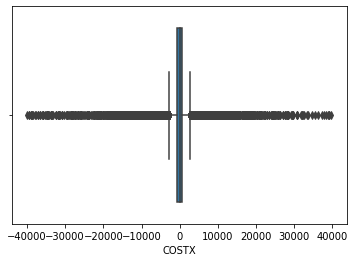

In [82]:
sns.boxplot(x=dfTest1['COSTX'])

In [83]:
# Borramos las columnas irrelevantes
dfTest1 = dfTest1.drop(['ZcostX'], axis=1)
z = np.abs(stats.zscore(dfTest1.COSTX))
#z = stats.zscore(dfTest1.COSTX)
dfTest1['ZcostX']=z

In [84]:
dfTest1['ZcostX'].describe()

count    16240.000000
mean         0.444019
std          0.896045
min          0.000010
25%          0.047405
50%          0.140043
75%          0.407239
max          8.415869
Name: ZcostX, dtype: float64

In [85]:
print('Dentro de 1 desviación estándar:', dfTest1.loc[dfTest1['ZcostX'] < 1,'ZcostX'].count(), round(dfTest1.loc[dfTest1['ZcostX'] < 1,'ZcostX'].count()/len(df)*100,2),'%')
print('Entre 1 y 2 desviaciones estándar:', dfTest1.loc[(dfTest1['ZcostX'] >= 1) & (dfTest1['ZcostX'] < 2),'ZcostX'].count())
print('Entre 2 y 3 desviaciones estándar:', dfTest1.loc[(dfTest1['ZcostX'] >= 2) & (dfTest1['ZcostX'] < 3),'ZcostX'].count())
print('Más de de 3 desviación estándar:', dfTest1.loc[dfTest1['ZcostX'] > 3,'ZcostX'].count())
print(dfTest1.loc[dfTest1['ZcostX'] < 1,'ZcostX'].count() + dfTest1.loc[(dfTest1['ZcostX'] >= 1) & (dfTest1['ZcostX'] < 2),'ZcostX'].count() + dfTest1.loc[(dfTest1['ZcostX'] >= 2) & (dfTest1['ZcostX'] < 3),'ZcostX'].count() + dfTest1.loc[dfTest1['ZcostX'] > 3,'ZcostX'].count())

Dentro de 1 desviación estándar: 14534 89.02 %
Entre 1 y 2 desviaciones estándar: 892
Entre 2 y 3 desviaciones estándar: 350
Más de de 3 desviación estándar: 464
16240


In [ ]:
#dfTest1.to_csv('{}/dataframe_imputado_test1.csv'.format(drivepath),index=False)

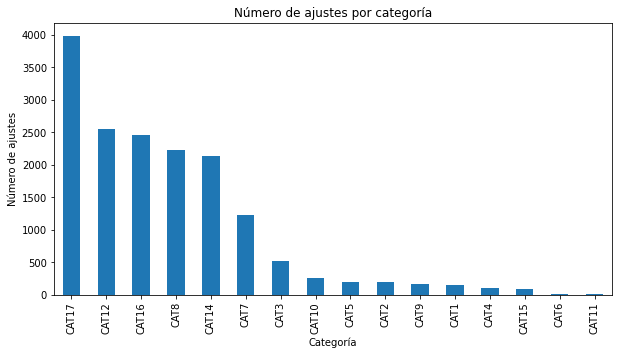

In [86]:
# Plotting a Histogram
dfTest1.CAT.value_counts().plot(kind='bar', figsize=(10,5))
# nlargest(40).
plt.title('Número de ajustes por categoría')
plt.ylabel('Número de ajustes')
plt.xlabel('Categoría');

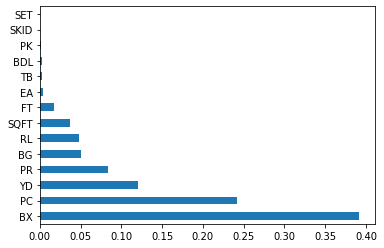

In [87]:
dfTest1.UOM.value_counts(normalize=True).plot.barh()
plt.show()

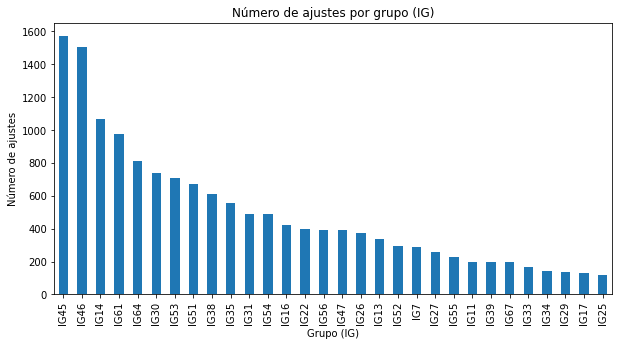

In [88]:
# Plotting a Histogram
dfTest1.IG.value_counts().nlargest(30).plot(kind='bar', figsize=(10,5))
plt.title('Número de ajustes por grupo (IG)')
plt.ylabel('Número de ajustes')
plt.xlabel('Grupo (IG)');

HTS119    23.17
HTS15     17.96
HTS24      9.40
HTS6       7.51
HTS61      4.63
HTS95      4.25
HTS48      3.17
HTS51      3.15
HTS55      2.65
HTS56      2.59
HTS121     2.48
HTS50      1.58
HTS16      1.47
HTS36      1.21
HTS46      0.99
Name: HTS, dtype: float64 %


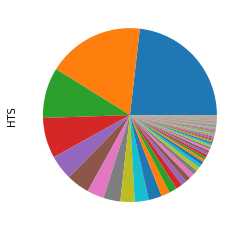

In [89]:
print(round(dfTest1.HTS.value_counts(normalize=True).nlargest(15)*100,2),'%')
dfTest1.HTS.value_counts(normalize=True).plot.pie(labels=None)
plt.show()

,QTY,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar,ZcostX
QTY,1.000000,0.140342,-0.332191,0.043265,0.007970,0.017983,0.022926,0.027114,0.004449,-0.691365,0.030287,-0.042595
COSTX,0.140342,1.000000,-0.020306,0.105836,-0.007572,-0.008074,-0.012636,-0.011018,-0.030653,-0.041509,0.051191,-0.129606
QTYBEFORE,-0.332191,-0.020306,1.000000,-0.006814,-0.033181,-0.053247,-0.082596,-0.086625,-0.016189,0.462976,-0.008179,-0.004117
QTYVAR,0.043265,0.105836,-0.006814,1.000000,-0.002622,0.023712,-0.003418,0.006050,0.006743,0.027517,0.992713,0.054746
PESO,0.007970,-0.007572,-0.033181,-0.002622,1.000000,0.297679,0.204623,0.169414,0.182238,-0.026592,-0.004236,0.175372
LARGO,0.017983,-0.008074,-0.053247,0.023712,0.297679,1.000000,0.105729,0.184111,0.204997,-0.036375,0.027853,0.183341
ALTO,0.022926,-0.012636,-0.082596,-0.003418,0.204623,0.105729,1.000000,0.715157,0.163450,-0.074907,-0.000840,0.200167
ANCHO,0.027114,-0.011018,-0.086625,0.006050,0.169414,0.184111,0.715157,1.000000,0.098206,-0.070793,0.007938,0.154482
CONTRPERC,0.004449,-0.030653,-0.016189,0.006743,0.182238,0.204997,0.163450,0.098206,1.000000,-0.015454,0.005530,0.373415
Zqty,-0.691365,-0.041509,0.462976,0.027517,-0.026592,-0.036375,-0.074907,-0.070793,-0.015454,1.000000,0.029859,0.096558


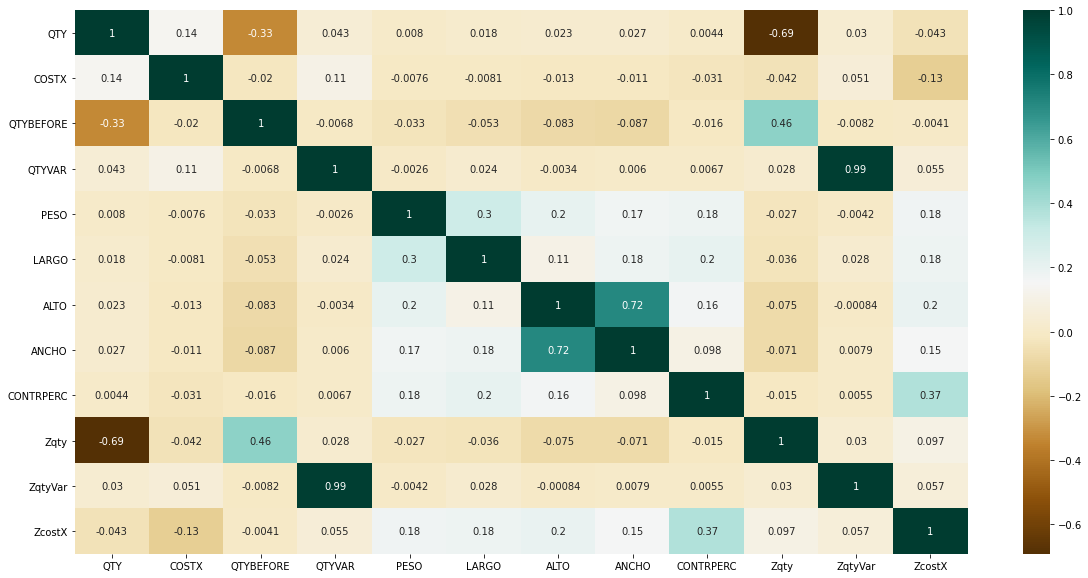

In [92]:
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
c= dfTest1.corr()
sns.heatmap(c,cmap='BrBG',annot=True)
c

In [ ]:
# Llamativo ALTO-ANCHO, tal vez la forma de las cajas?

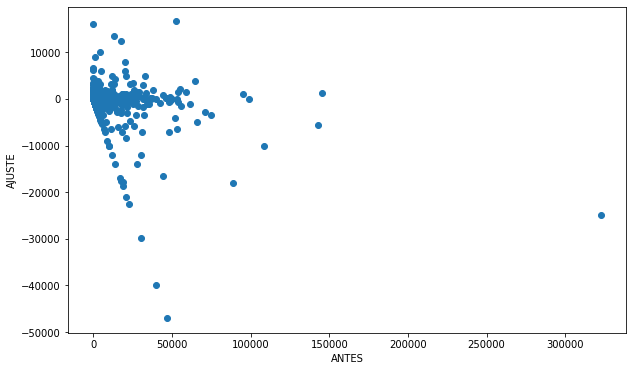

In [91]:
# Plotting a scatter plot
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(dfTest1['QTYBEFORE'], dfTest1['QTY'])
ax.set_xlabel('ANTES')
ax.set_ylabel('AJUSTE')
plt.show()

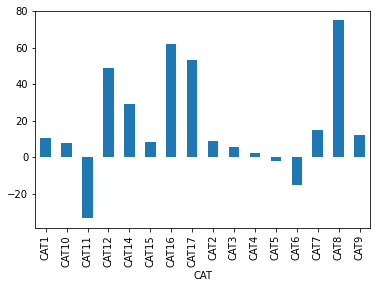

In [93]:
dfTest1.groupby('CAT')['QTYVAR'].mean().plot.bar()
#print(result)
plt.show()

In [94]:
dfTest1.describe()

,QTY,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar,ZcostX
count,16240.000000,16240.00000,16240.000000,16240.000000,16240.000000,16240.000000,16240.000000,16240.000000,16240.000000,16240.000000,16240.000000,16240.000000
mean,-22.994720,-150.19289,534.860238,46.021944,13.534780,53.915378,4.820516,5.699760,0.085738,0.088864,0.117343,0.444019
std,869.728353,4736.88075,4472.157526,913.358883,42.943403,64.882463,4.617638,4.324511,0.408329,0.678324,0.865419,0.896045
min,-47000.000000,-40013.93500,0.000000,-100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000162,0.000057,0.000010
25%,-6.000000,-727.16260,2.000000,-50.000000,0.460000,6.000000,1.500000,2.500000,0.000000,0.016681,0.046461,0.047405
50%,-1.000000,-33.14560,18.000000,-1.180000,2.020000,12.000000,3.500000,5.500000,0.010000,0.019041,0.052980,0.140043
75%,4.000000,614.16730,113.000000,46.970000,9.800000,102.000000,7.250000,8.000000,0.022500,0.026120,0.142078,0.407239
max,16624.000000,39709.66140,322475.000000,73950.000000,3250.000000,241.000000,50.500000,48.000000,4.630000,36.951524,70.659376,8.415869


In [95]:
dfTest1.sample(5)

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,...,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar,ZcostX
7281,2019-05-09,SKU4237,18C3,-60.0,18,C,3,LOC4,IG46,HTS119,1,1,...,CAT17,-2840.2821,231.0,-25.97,2.08,96.50,3.25,3.25,0.02,0.028942,0.073987,0.567921
9043,2019-12-03,SKU10986,25D1,-12.0,25,D,1,LOC4,IG55,HTS95,1,1,...,CAT16,-31.9733,576.0,-2.08,62.00,194.00,4.00,5.00,0.02,0.008815,0.051145,0.024958
2939,2018-08-24,SKU8019,13H5,-40.0,13,H,5,LOC4,IG45,HTS24,1,1,...,CAT17,-495.2120,40.0,-100.00,0.40,8.25,3.00,6.75,0.02,0.013210,0.144772,0.072839
8314,2019-08-28,SKU11170,12W4,10.0,12,W,4,LOC4,IG51,HTS119,1,1,...,CAT16,242.3749,390.0,2.56,0.10,2.25,1.25,1.50,0.00,0.026120,0.046708,0.082877
16814,2019-01-14,SKU7337,01K2,3.0,1,K,2,LOC4,IG2,HTS97,2,0,...,CAT1,1627.9173,22.0,13.64,47.00,14.00,2.00,14.00,0.01,0.020614,0.036114,0.375387


In [96]:
dfTest1.query('LARGO > ALTO')

,TDATE,SKU,LOC,QTY,AISLE,COLUMN,SHELF,TYPE,IG,HTS,CLASS,PLANNING,...,CAT,COSTX,QTYBEFORE,QTYVAR,PESO,LARGO,ALTO,ANCHO,CONTRPERC,Zqty,ZqtyVar,ZcostX
28,2018-02-10,SKU3992,12I6,-144.0,12,I,6,LOC4,IG46,HTS119,1,1,...,CAT17,-8177.0401,144.0,-100.00,1.7,36.5,3.250,3.00,0.01,0.095015,0.144772,1.694595
29,2018-02-10,SKU3992,1.70E+06,-4.0,17,E,5,LOC4,IG46,HTS119,1,1,...,CAT17,-227.1400,102.0,-3.92,1.7,36.5,3.250,3.00,0.01,0.015108,0.052904,0.016245
30,2018-02-10,SKU3992,17V1,3.0,17,V,1,LOC4,IG46,HTS119,1,1,...,CAT17,170.3550,158.0,1.90,1.7,36.5,3.250,3.00,0.01,0.020614,0.047339,0.067673
31,2018-02-10,SKU3993,13L6,-6.0,13,L,6,LOC4,IG46,HTS119,1,1,...,CAT17,-340.7100,97.0,-6.19,1.7,36.5,3.250,3.00,0.04,0.013534,0.055074,0.040221
32,2018-02-10,SKU3993,13T1,-52.0,13,T,1,LOC4,IG46,HTS119,1,1,...,CAT17,-2952.8200,53.0,-98.11,1.7,36.5,3.250,3.00,0.04,0.022649,0.142965,0.591679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17002,2020-12-13,SKU8964,23C10,1.0,23,C,10,LOC5,IG5,HTS67,1,0,...,CAT2,316.3834,0.0,100.00,45.0,162.0,2.375,6.00,0.00,0.019041,0.046461,0.098502
17003,2020-12-13,SKU8971,21I2,2.0,21,I,2,LOC4,IG5,HTS67,1,0,...,CAT2,626.9100,0.0,100.00,45.0,162.0,2.375,6.00,0.00,0.019827,0.046461,0.164059
17004,2020-12-13,SKU8972,22F8,15.0,22,F,8,LOC4,IG5,HTS67,1,0,...,CAT2,4959.6974,11.0,136.36,45.0,162.0,2.375,6.00,0.00,0.030053,0.081227,1.078779
17005,2020-12-13,SKU8972,24I4,-4.0,24,I,4,LOC4,IG5,HTS67,1,0,...,CAT2,-1322.5860,4.0,-100.00,45.0,162.0,2.375,6.00,0.00,0.015108,0.144772,0.247511


In [97]:
print("Peso  (0):",dfTest1.loc[dfTest1['PESO']==0].shape[0]);
print("Largo (0):",dfTest1.loc[dfTest1['LARGO']==0].shape[0]);
print("Ancho (0):",dfTest1.loc[dfTest1['ANCHO']==0].shape[0]);
print("Alto  (0):",dfTest1.loc[dfTest1['ALTO']==0].shape[0]);

Peso  (0): 1004
Largo (0): 1282
Ancho (0): 1282
Alto  (0): 1282


In [98]:
# Descartar dimensiones

In [99]:
dfTest1.dtypes

TDATE        datetime64[ns]
SKU                  object
LOC                  object
QTY                 float64
AISLE                object
COLUMN               object
SHELF                object
TYPE                 object
IG                   object
HTS                  object
CLASS                object
PLANNING             object
ABC                  object
UOM                  object
CAT                  object
COSTX               float64
QTYBEFORE           float64
QTYVAR              float64
PESO                float64
LARGO               float64
ALTO                float64
ANCHO               float64
CONTRPERC           float64
Zqty                float64
ZqtyVar             float64
ZcostX              float64
dtype: object

In [107]:
# Backup
dfTest2 = dfTest1
# dfTest2.to_csv('{}/dataframe_imputado_test2.csv'.format(drivepath),index=False)

In [108]:
# Borramos las columnas que no serán utilizados en este primer intento
dfTest1 = dfTest1.drop(['TDATE','SKU','LOC','COLUMN','SHELF','TYPE','QTYBEFORE','PESO','LARGO','ALTO','ANCHO','Zqty','ZqtyVar','ZcostX','QTY','CONTRPERC'], axis=1)

In [109]:
dfTest1['PLANNING'] =dfTest1['CLASS'] + "/" + dfTest1['PLANNING']

In [110]:
dfTest1 = dfTest1.drop(['CLASS'], axis=1)

In [111]:
dfTest1['PLANNING'].value_counts()

1/1    13428
1/0     1590
2/0     1222
Name: PLANNING, dtype: int64

In [112]:
dfTest1.dtypes

AISLE        object
IG           object
HTS          object
PLANNING     object
ABC          object
UOM          object
CAT          object
COSTX       float64
QTYVAR      float64
dtype: object

In [113]:
dfTest1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16240 entries, 0 to 17006
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AISLE     16240 non-null  object 
 1   IG        16240 non-null  object 
 2   HTS       16240 non-null  object 
 3   PLANNING  16240 non-null  object 
 4   ABC       16240 non-null  object 
 5   UOM       16240 non-null  object 
 6   CAT       16240 non-null  object 
 7   COSTX     16240 non-null  float64
 8   QTYVAR    16240 non-null  float64
dtypes: float64(2), object(7)
memory usage: 1.2+ MB


In [140]:
dfTest1.reset_index(drop=True, inplace=True)

In [ ]:
# dfTest1.to_csv('{}/dataframe_imputado_test1.csv'.format(drivepath),index=False)

In [142]:
# Get the position of categorical columns
catColumnsPos = [dfTest1.columns.get_loc(col) for col in list(dfTest1.select_dtypes('object').columns)]
print('Categorical columns : {}'.format(list(dfTest1.select_dtypes('object').columns)))
print('Categorical columns position : {}'.format(catColumnsPos))

Categorical columns : ['AISLE', 'IG', 'HTS', 'PLANNING', 'ABC', 'UOM', 'CAT']
Categorical columns position : [0, 1, 2, 3, 4, 5, 6]


In [143]:
# Get the position of numerical columns
numColumnsPos = [dfTest1.columns.get_loc(col) for col in list(dfTest1.select_dtypes('float64').columns)]
print('Numerical columns : {}'.format(list(dfTest1.select_dtypes('float64').columns)))
print('Numerical columns position : {}'.format(numColumnsPos))

Numerical columns : ['COSTX', 'QTYVAR']
Numerical columns position : [7, 8]


In [144]:
numdf = dfTest1[list(dfTest1.select_dtypes('float64').columns)]

In [145]:
scaled_features = StandardScaler().fit_transform(numdf.values)
scaled_features_df = pd.DataFrame(scaled_features, index=numdf.index, columns=numdf.columns)
scaled_features_df

,COSTX,QTYVAR
0,-0.029490,-0.053269
1,0.092837,-0.023017
2,0.266324,0.004356
3,-0.024631,-0.060342
4,-0.077448,-0.062553
...,...,...
16235,0.098502,0.059100
16236,0.164059,0.059100
16237,1.078779,0.098911
16238,-0.247511,-0.159878


In [146]:
scaled_features_df.describe()

,COSTX,QTYVAR
count,1.624000e+04,1.624000e+04
mean,-7.103159e-17,-1.779758e-17
std,1.000031e+00,1.000031e+00
min,-8.415869e+00,-1.598785e-01
25%,-1.218075e-01,-1.051338e-01
50%,2.471054e-02,-5.168111e-02
75%,1.613686e-01,1.038020e-03
max,8.415049e+00,8.091699e+01


In [147]:
catdf = dfTest1[list(dfTest1.select_dtypes('object').columns)]

In [148]:
print("catdf",catdf.shape)
print("scaled_features_df",scaled_features_df.shape)
print(catdf.head(5))
print(scaled_features_df.head(5))
dfNoSupervisado1 = pd.concat((catdf, scaled_features_df), axis = 1)
dfNoSupervisado1

catdf (16240, 7)
scaled_features_df (16240, 2)
  AISLE    IG     HTS PLANNING ABC UOM    CAT
0    17  IG56  HTS119      1/1   B  PC  CAT17
1    17  IG56  HTS119      1/1   B  PC  CAT17
2    17  IG56  HTS119      1/1   C  PC  CAT17
3    17  IG56  HTS119      1/1   B  PC  CAT17
4    15  IG56  HTS119      1/1   C  PC  CAT17
      COSTX    QTYVAR
0 -0.029490 -0.053269
1  0.092837 -0.023017
2  0.266324  0.004356
3 -0.024631 -0.060342
4 -0.077448 -0.062553


,AISLE,IG,HTS,PLANNING,ABC,UOM,CAT,COSTX,QTYVAR
0,17,IG56,HTS119,1/1,B,PC,CAT17,-0.029490,-0.053269
1,17,IG56,HTS119,1/1,B,PC,CAT17,0.092837,-0.023017
2,17,IG56,HTS119,1/1,C,PC,CAT17,0.266324,0.004356
3,17,IG56,HTS119,1/1,B,PC,CAT17,-0.024631,-0.060342
4,15,IG56,HTS119,1/1,C,PC,CAT17,-0.077448,-0.062553
...,...,...,...,...,...,...,...,...,...
16235,23,IG5,HTS67,1/0,C,BX,CAT2,0.098502,0.059100
16236,21,IG5,HTS67,1/0,C,BX,CAT2,0.164059,0.059100
16237,22,IG5,HTS67,1/0,C,BX,CAT2,1.078779,0.098911
16238,24,IG5,HTS67,1/0,C,BX,CAT2,-0.247511,-0.159878


In [133]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [154]:
dfNoSupervisado1.to_csv("/content/gdrive/MyDrive/TDGdata/dfstd050621.csv", index = False)

In [155]:
dfTest1.to_csv("/content/gdrive/MyDrive/TDGdata/dfNostd050621.csv", index = False)